# TIF to JPG and TFRecords in multiple resolutions
In this notebook we will transform the huge train images into both discrete jpeg+png files and sharded TFRecords format.
When creating TFRecords of a dataset it is most efficient for the processing pipeline to have TFRecords of a certain size, generally >10MBytes, to benefit from I/O prefetching. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from PIL import Image
import hashlib
from io import BytesIO
from skimage import io
import contextlib2
import json
import cv2
import os, shutil  
from functools import partial
%matplotlib inline  

## References
This notebook uses/modifies some code snippets from these notebooks:
* [Global Wheat to TFRecords](https://www.kaggle.com/mistag/global-wheat-to-tfrecords) (own work)
* [HuBMap: Read data and build TFRecords](https://www.kaggle.com/marcosnovaes/hubmap-read-data-and-build-tfrecords)   

In addition some sample code from Keras documentation.

# TFRecords creation using patches
The super-resolution cell scan images need to be split into patches (or tiles if you like).   

Here we go for 1024x1024 as the primary tile (patch) size. Adjust the IMG_SIZE variable further below to suit needs. We also create downscaled versions of 512x512, 256x256 and 128x128, both in TFRecord format and as separate jpeg files (png for masks).   
This dataset also includes an anatomy mask. We will use this mask to split the TFRecords into two sets: One that includes the Cortex mask (containing the glomeruli) and one for everything else. This allow us to easily select how much "other stuff" to include during training.

In [2]:
# A few helper functions for reading in image and masks (from json)

def read_tif_file(fname):
    img = io.imread(fname)
    img = np.squeeze(img)
    if img.shape[0] == 3: # swap axes as required
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
    return img

def read_mask_file(fname, mshape):
    with open(fname) as f:
        mdata = json.load(f)
        polys = []
        for index in range(mdata.__len__()):
            if (mdata[index]['properties']['classification']['name'] == 'Cortex') or (mdata[index]['properties']['classification']['name'] == 'glomerulus'):
                geom = np.array(mdata[index]['geometry']['coordinates'])
                if geom.shape[0] == 1:
                    polys.append(geom)
                else:
                    for j in range(geom.shape[0]):
                        polys.append(np.array([geom[j][0]]).astype(int))
        mask = np.zeros(mshape, dtype=np.int8)
        cv2.fillPoly(mask, polys, 1)
        mask = mask.astype(bool, copy=False)
    return mask

The function below creates a TFRecord from a single patch. The image is stored as JPEG, while the mask is stored as PNG (lossless). We also put in some extra metadata. The anatomy mask is used to determine if the patch is part of Cortex or not. Adjust the threshold (number of pixles) as required.

In [3]:
# patches are stored as jpeg, masks as PNG
def create_tf_example(patch, m_patch, fid, x, y, size):
    filename = fid+'.tiff'
    height = size # Image height
    width = size # Image width
    buf= BytesIO()
    im = Image.fromarray(np.uint8(patch))
    im.save(buf, format= 'JPEG') # encode to jpeg in memory
    encoded_image_data= buf.getvalue()
    image_format = b'jpeg'
    source_id = fid+'-'+str(x)+'-'+str(y) # must be unique
    # A hash of the image is used in some frameworks
    key = hashlib.sha256(encoded_image_data).hexdigest()
    # Mask encoding
    buf= BytesIO()
    mim = Image.fromarray(np.uint8(m_patch))
    mim.save(buf, format= 'PNG') # encode to png in memory
    encoded_mask_data= buf.getvalue()
    mask_format = b'png'
    
    tf_record = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode()])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[source_id.encode()])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image_data])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode()])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/patch-x': tf.train.Feature(int64_list=tf.train.Int64List(value=[x])),
        'image/patch-y': tf.train.Feature(int64_list=tf.train.Int64List(value=[y])),
        'mask/patch-x': tf.train.Feature(int64_list=tf.train.Int64List(value=[x])),
        'mask/patch-y': tf.train.Feature(int64_list=tf.train.Int64List(value=[y])),
        'mask/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_mask_data])),
        'mask/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_format])),
    }))
    
    return tf_record

## Create shards + discrete images
We create two sharded datasets here, 20 shards will give a granularity of 5% for train/validate split. Notice that we rename all .jpg and .png file extensions to .jpg1 and .png1 to prevent Kaggle to produce thousands of thumbnails from all these images.

In [4]:
%%time
PATH = '/kaggle/input/hubmap-kidney-segmentation/train/'
IMG_SIZE = 1024 # adjust according to desired tile size
SCALES = 3 # number of times to downscale each patch (generate SCALES+1 sets of images)
SCALE_FACTOR = 2 # scale factor to use for each set, adjust according to needs
img_sizes = np.zeros(SCALES+1, dtype=int)
img_sizes[0] = IMG_SIZE
for i in range(SCALES):
    img_sizes[i+1] = int(img_sizes[i]/SCALE_FACTOR)
# create directories for jpeg/png images
for i in range(len(img_sizes)):
    os.makedirs('./'+str(img_sizes[i]))
    os.makedirs('./'+str(img_sizes[i])+'/Tissue')
    os.makedirs('./'+str(img_sizes[i])+'/Bkgnd')
filelist = glob.glob(PATH+'*.tiff')

def open_sharded_tfrecords(exit_stack, base_path, size, num_shards):
    tf_record_output_filenames = [
        '{}-{}-{:04d}-of-{:04d}.tfrecord'.format(base_path, size, idx, num_shards)
        for idx in range(num_shards)
        ]
    tfrecords = [
        exit_stack.enter_context(tf.io.TFRecordWriter(file_name))
        for file_name in tf_record_output_filenames
    ]
    return tfrecords

def wr_images(fname, image, mask):
    cv2.imwrite(fname, image)
    os.rename(fname, fname.replace('.jpg', '.jpg1'))
    cv2.imwrite(fname.replace('jpg', 'png'), mask.astype(int)) 
    os.rename(fname.replace('jpg', 'png'), fname.replace('.jpg', '.png1'))

s_th = 90  # saturation threshold
p_th = IMG_SIZE*IMG_SIZE//16 # pixle count threshold
num_shards=20
output_filebase1='./Tissue' # dataset covering Tissue
output_filebase2='./Bkgnd' # dataset covering everything else
gcnt, ncnt = np.zeros(num_shards, dtype=int), np.zeros(num_shards, dtype=int)

# A context2.ExitStack is used to automatically close all the TFRecords created 
with contextlib2.ExitStack() as tf_record_close_stack:
    output_tfrecords1 = []
    output_tfrecords2 = []
    for scnt in range(SCALES+1):
        output_tfrecords1.append(open_sharded_tfrecords(tf_record_close_stack, output_filebase1, img_sizes[scnt], num_shards))
        output_tfrecords2.append(open_sharded_tfrecords(tf_record_close_stack, output_filebase2, img_sizes[scnt], num_shards))
    for file in filelist:
        print(file)
        fid = file.replace('\\','.').replace('/','.').split('.')[-2]
        img, mask = np.zeros(10), np.zeros(10) 
        img = read_tif_file(file)
        dims = np.array(img.shape[:2])
        mask = read_mask_file(file.split('.')[0]+'.json', dims)
        for x in range(img.shape[0]//IMG_SIZE):
            for y in range(img.shape[1]//IMG_SIZE):
                # Extract patch
                patch = img[x*IMG_SIZE:(x+1)*IMG_SIZE, y*IMG_SIZE:(y+1)*IMG_SIZE]
                m_patch = mask[x*IMG_SIZE:(x+1)*IMG_SIZE, y*IMG_SIZE:(y+1)*IMG_SIZE]*255
                # separate tissue from bakground
                IsTissue = False
                _, s, _ = cv2.split(cv2.cvtColor(patch, cv2.COLOR_BGR2HSV))
                if (s>s_th).sum() > p_th:
                    IsTissue=True
                tf_record = create_tf_example(patch, m_patch, fid, x, y, size=img_sizes[0])
                if IsTissue:
                    output_shard_index1 = (x+y) % num_shards
                    output_tfrecords1[0][output_shard_index1].write(tf_record.SerializeToString())
                    gcnt[output_shard_index1] += 1
                    wr_images('./'+str(img_sizes[0])+'/Tissue/'+fid+'-'+str(x)+'-'+str(y)+'.jpg', patch, m_patch)
                else:
                    output_shard_index2 = (x+y) % num_shards
                    output_tfrecords2[0][output_shard_index2].write(tf_record.SerializeToString())
                    ncnt[output_shard_index2] += 1
                    wr_images('./'+str(img_sizes[0])+'/Bkgnd/'+fid+'-'+str(x)+'-'+str(y)+'.jpg', patch, m_patch)
                # create downscaled images
                for s in range(SCALES): 
                    spatch = cv2.resize(patch, dsize=(img_sizes[s+1], img_sizes[s+1]), interpolation = cv2.INTER_AREA)
                    sm_patch = cv2.resize(m_patch.astype(int), dsize=(img_sizes[s+1], img_sizes[s+1]), interpolation = cv2.INTER_NEAREST)
                    tf_record = create_tf_example(spatch, sm_patch, fid, x, y, size=img_sizes[s+1])
                    if IsTissue:
                        output_tfrecords1[s+1][output_shard_index1].write(tf_record.SerializeToString())
                        wr_images('./'+str(img_sizes[1+s])+'/Tissue/'+fid+'-'+str(x)+'-'+str(y)+'.jpg', spatch, sm_patch)
                    else:
                        output_tfrecords2[s+1][output_shard_index2].write(tf_record.SerializeToString())
                        wr_images('./'+str(img_sizes[1+s])+'/Bkgnd/'+fid+'-'+str(x)+'-'+str(y)+'.jpg', spatch, sm_patch)

/kaggle/input/hubmap-kidney-segmentation/train/095bf7a1f.tiff
/kaggle/input/hubmap-kidney-segmentation/train/e79de561c.tiff
/kaggle/input/hubmap-kidney-segmentation/train/0486052bb.tiff
/kaggle/input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff
/kaggle/input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff
/kaggle/input/hubmap-kidney-segmentation/train/54f2eec69.tiff
/kaggle/input/hubmap-kidney-segmentation/train/1e2425f28.tiff
/kaggle/input/hubmap-kidney-segmentation/train/cb2d976f4.tiff
CPU times: user 20min 47s, sys: 1min 34s, total: 22min 22s
Wall time: 21min 28s


Create a .json file with a few useful parameters we might need during training/inference:

In [5]:
dparams = {
    "IMG_SIZE": IMG_SIZE,
    "SCALE_FACTOR": SCALE_FACTOR,
    "SAT_THRES": s_th,
    "PIXEL_THRES": p_th}
with open("dparams.json", "w") as json_file:
    json_file.write(json.dumps(dparams, indent = 4))

Export a table with number of images per TFRecord.

In [6]:
import pandas as pd

recsizes = []
for i in range(num_shards):
    for j in range(len(img_sizes)):
        recsizes.append([output_filebase1.split('/')[-1]+'-{}-{:04d}-of-{:04d}.tfrecord'.format(img_sizes[j],i, num_shards), gcnt[i]])
for i in range(num_shards):
    for j in range(len(img_sizes)):
        recsizes.append([output_filebase2.split('/')[-1]+'-{}-{:04d}-of-{:04d}.tfrecord'.format(img_sizes[j], i, num_shards), ncnt[i]])
df = pd.DataFrame(recsizes, columns=['File', 'ImgCount'])
df.to_pickle('./record_stats.pkl')
df.sample(5)

File  ImgCount
102    Bkgnd-256-0005-of-0020.tfrecord       183
7     Tissue-128-0001-of-0020.tfrecord       164
39    Tissue-128-0009-of-0020.tfrecord       164
80    Bkgnd-1024-0000-of-0020.tfrecord       149
56   Tissue-1024-0014-of-0020.tfrecord       149

# Check the output files
The final check is to load and plot a couple of TFRecords and verify that everything loads OK.

In [7]:
def plot_imgs(dataset):
    fig = plt.figure(figsize=(18,18))
    idx=1
    for raw_record in dataset.take(36):
        axes = fig.add_subplot(6, 6, idx)
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        img_encoded=example.features.feature['image/encoded'].bytes_list.value[0]
        img = Image.open(BytesIO(img_encoded))
        mask_encoded=example.features.feature['mask/encoded'].bytes_list.value[0]
        mask = Image.open(BytesIO(mask_encoded))
        plt.setp(axes, xticks=[], yticks=[])
        plt.imshow(img)
        plt.imshow(mask, alpha=0.25)
        idx=idx+1

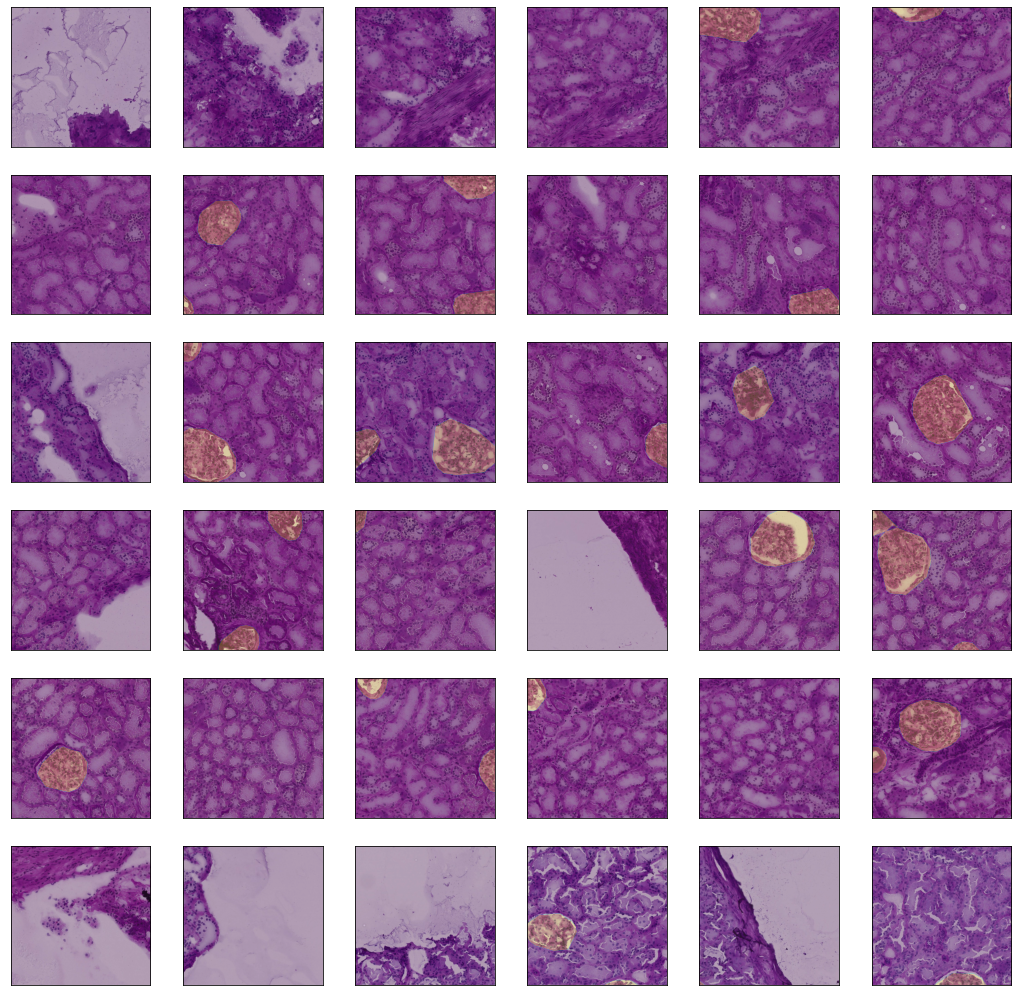

In [8]:
fname='./Tissue-1024-0004-of-0020.tfrecord'
dataset = tf.data.TFRecordDataset(fname)
plot_imgs(dataset)

The downsampled dataset should be the same images:

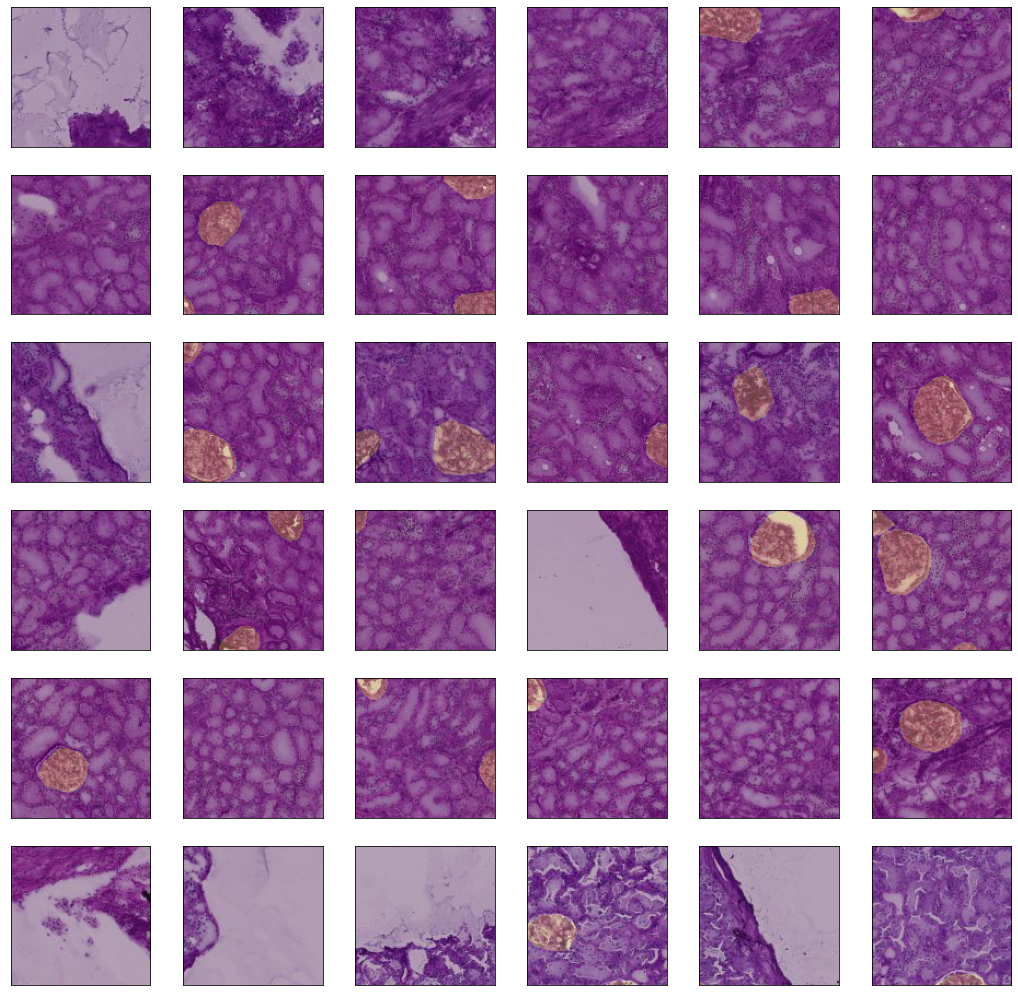

In [9]:
fname='./Tissue-128-0004-of-0020.tfrecord'
dataset = tf.data.TFRecordDataset(fname)
plot_imgs(dataset)

## Reconstruct Tissue
As a final test, let us reconstruct the Tissue of one of the train images from discrete images.

In [10]:
filelist = glob.glob('./256/Tissue/095bf7a1f*.jpg1')

def get_index(fname):
    x=fname.split('.')[-2].split('-')[-2]
    y=fname.split('.')[-2].split('-')[-1]
    return int(x),int(y)

x, y = np.zeros(len(filelist), dtype=int), np.zeros(len(filelist), dtype=int)
idx = 0
for f in filelist:
    x[idx], y[idx] = get_index(f)
    idx += 1

In [11]:
cortex_img = np.zeros([(x.max()-x.min()+1)*256, (y.max()-y.min()+1)*256, 3], dtype=int)
cortex_mask = np.zeros([(x.max()-x.min()+1)*256, (y.max()-y.min()+1)*256], dtype=int)

for f in filelist:
    img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    xi, yi = get_index(f)
    cortex_img[(xi-x.min())*256:(xi-x.min()+1)*256,(yi-y.min())*256:(yi-y.min()+1)*256,:] = img
    img = cv2.imread(f.replace('jpg', 'png'), cv2.IMREAD_UNCHANGED)
    xi, yi = get_index(f)
    cortex_mask[(xi-x.min())*256:(xi-x.min()+1)*256,(yi-y.min())*256:(yi-y.min()+1)*256] = img

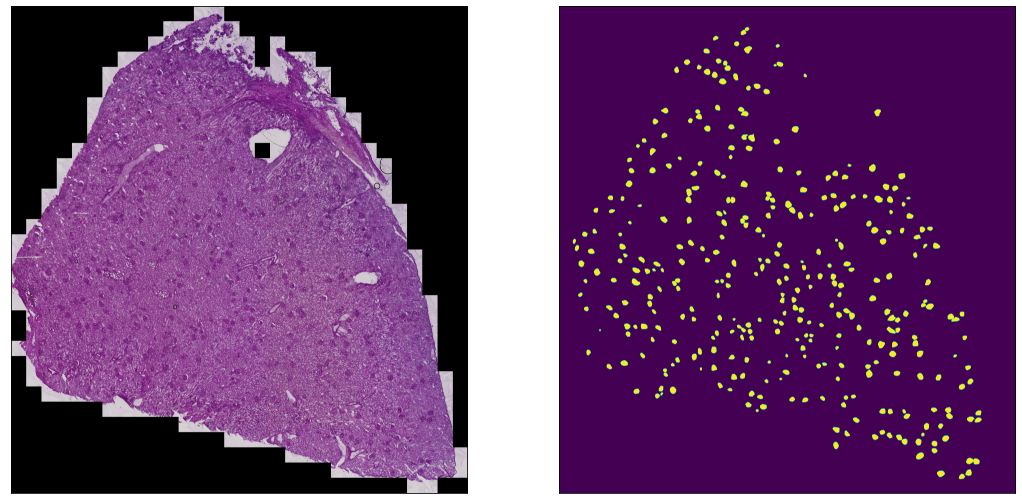

In [12]:
fig = plt.figure(figsize=(18,9))
axes = fig.add_subplot(1, 2, 1)
plt.setp(axes, xticks=[], yticks=[])
plt.imshow(cortex_img)
axes = fig.add_subplot(1, 2, 2)
plt.setp(axes, xticks=[], yticks=[])
plt.imshow(cortex_mask);

Yup, that looks OK!   
Here is the image directory structure:

In [13]:
base = './'
for root, dirs, files in os.walk(base):
    level = root.replace(base, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)
    if level > 0:
        for f in files[:2]:
            print('{}{}'.format(subindent, f))

/
128/
    Tissue/
        54f2eec69-6-12.png1
        1e2425f28-4-8.jpg1
    Bkgnd/
        aaa6a05cc-11-0.jpg1
        095bf7a1f-35-29.jpg1
512/
    Tissue/
        54f2eec69-6-12.png1
        1e2425f28-4-8.jpg1
    Bkgnd/
        aaa6a05cc-11-0.jpg1
        095bf7a1f-35-29.jpg1
1024/
    Tissue/
        54f2eec69-6-12.png1
        1e2425f28-4-8.jpg1
    Bkgnd/
        aaa6a05cc-11-0.jpg1
        095bf7a1f-35-29.jpg1
256/
    Tissue/
        54f2eec69-6-12.png1
        1e2425f28-4-8.jpg1
    Bkgnd/
        aaa6a05cc-11-0.jpg1
        095bf7a1f-35-29.jpg1
